

The provided introduction provides an overview of the "Spam Text Message Classification" dataset, the problem at hand (spam detection), and the structure of the notebook. Here's a slight rewrite for clarity:

**Introduction**

The **"Spam Text Message Classification"** dataset comprises **5,572 text messages** categorized as either **spam or ham** (non-spam). Among these messages, **4,827** are labeled as **ham**, while **747** are labeled as **spam**. The dataset, curated by **Team AI**, was last updated in **October 2020**.

The primary objective of this dataset is to facilitate the development and evaluation of text classification models for **spam detection**. This task is integral to natural language processing, as spam messages can be a substantial concern for both individuals and organizations.

**The Challenge**

The challenge at hand is to accurately distinguish between **spam and legitimate (ham) messages**. Spam messages, often sent to a large audience, may intend to promote products, services, or engage in fraudulent activities. Detecting spam is a complex task due to evolving spammer tactics and the varying content of spam messages.

**Notebook Structure**

The notebook is structured as follows:

1. **SetUp**: Importing necessary modules, defining hyperparameters, and constants.

2. **Data Loading**: Loading the dataset for subsequent analysis.

3. **Text Preprocessing**: Preparing the data for modeling through tokenization, cleaning, and padding.

4. **Transformer Network Architecture**: Creating the transformer network architecture, including token and word embeddings and position embeddings.

5. **Transformer Model Training**: Training the transformer model and evaluating its performance on testing data. Despite the appearance of divergence in the training curve, the model performs well and generalizes effectively to new data.

6. **Transformer Model Predictions**: Developing a function to input text and allow the transformer to classify it as spam or ham.

This organized structure ensures clarity and ease of understanding, making it simpler to implement and modify the model as needed.

The "SetUp" section is responsible for **importing essential modules** necessary for the **execution of the program**. Additionally, it **defines hyperparameters and constants** crucial for the **successful program implementation**. This section sets the stage for the subsequent steps in the notebook.

In [ ]:
# Common imports
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Data processing and visualization imports
import string
import pandas as pd
import plotly.express as px
import tensorflow.data as tfd  # There might be a typo here, it should be 'tensorflow.data' not 'tensorflow.data'
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Model building imports
from sklearn.utils import class_weight
from tensorflow.keras import callbacks
from tensorflow.keras import Model, layers


In [ ]:
# Define hyperparameters
num_heads = 4  # Number of self-attention heads
embed_dim = 256  # Dimension of the token embeddings
ff_dim = 128  # Dimension of the feedforward layer
vocab_size = 10000  # Size of the vocabulary
max_seq_len = 40  # Maximum sequence length

# Set constants
learning_rate = 1e-3  # Learning rate for the optimizer
epochs = 100  # Number of training epochs
batch_size = 32  # Batch size for training

# Define training callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("SpamDetector.h5", save_best_only=True)
]


In [ ]:
# Set up random seed for reproducibility
random_seed = 123  # You can choose any integer value as the random seed
np.random.seed(random_seed)  # Set the random seed for NumPy
tf.random.set_seed(random_seed)  # Set the random seed for TensorFlow


The provided explanation accurately describes the purpose and importance of the "Data Loading" section in a data analysis or machine learning pipeline. It emphasizes that loading the data is a crucial initial step that enables further data processing and analysis.

In [ ]:
# Specify the path to the SPAM text message dataset
data_path = '/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv'

# Load the dataset using the pandas library
data_frame = pd.read_csv(data_path)

# Display the first five rows of the dataset
data_frame.head()


To gather more detailed information about the data, you can perform the following steps:

1. Display the data types of each column using `data_frame.dtypes` to understand how the data is structured.

2. Use `data_frame.info()` to obtain an overview of the dataset, including the number of non-null values in each column and the memory usage.

3. Check for any missing values using `data_frame.isnull().sum()`. This will show the number of missing values in each column.

4. For numerical columns, use `data_frame.describe()` to get summary statistics such as mean, standard deviation, minimum, maximum, and quartiles.

5. For categorical columns, you can use `data_frame['column_name'].value_counts()` to see the frequency of each unique value in a specific column.

These steps will provide a more comprehensive understanding of the dataset and its characteristics.

In [ ]:
import plotly.express as px

# Get the counts of each class and their names
class_dis = data_frame['Category'].value_counts()
class_names = class_dis.index

# Create the Pie Chart
fig = px.pie(names=class_names,
             values=class_dis,
             color=class_names,
             hole=0.4,
             labels={'values': 'Count', 'names': 'Class'},
             title='Class Distribution of Spam Text Messages')

# Customize the layout
fig.update_layout(
    margin=dict(l=10, r=10, t=60, b=10),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),


Upon analyzing the dataset, it becomes evident that there is a **significant class imbalance**. Approximately **86.6% of the data points** are labeled as **"ham,"** while **only 13.4%** are labeled as **"spam."** This substantial imbalance in class distribution implies that even a random guess could achieve an **86% accuracy rate,** making it difficult to build a reliable and effective prediction model. The challenge of **class imbalance** will be addressed in the next section.

In [ ]:
# Data set size
N_SAMPLES = len(data_frame)

print(f"Total Number of Samples : {N_SAMPLES}")

The data is **neither too big, nor too small**. ALthough, it is still **quite small**.

In [ ]:
max_len = max([len(text) for text in data_frame.Message])
print(f"Maximum Length Of Input Sequence(Chars) : {max_len}")

In [ ]:
# Extract X and y from the data frame
X = data_frame['Message'].tolist()
y = data_frame['Category'].tolist()


# Initialize label encoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Print the first 5 elements of X and y
print(f'X[:5]: \n{X[:5]}\n')
print(f'y[:5]: {y[:5]}\n')
print(f"Label Mapping : {label_encoder.inverse_transform(y[:5])}")

The data loading step has been successfully completed. However, the data is currently in a raw format and needs to be preprocessed to make it compatible with the model.
-------
One essential aspect of preprocessing is creating a label mapping dictionary. There are multiple ways to create such a dictionary. One method is manual creation, which allows for greater control and flexibility but can be time-consuming. An alternative approach is to use a label encoder, which assigns a unique numerical label to each class, starting from zero. For instance, in our case,**"ham"** is encoded as 0, and **"spam"** as 1. This method simplifies the mapping of each class to its corresponding numerical label without requiring manual dictionary creation. In the current case, where only two classes exist, both manual dictionary creation and a label encoder would be equally effective.

# **Text Vectorization**
---


Using cost-sensitive learning to address class imbalances is a valid and effective approach, especially when working with imbalanced text data. It allows the model to give higher importance to the minority class, improving its ability to correctly classify the less frequent class (e.g., spam messages).

In many real-world scenarios, the cost of misclassifying the minority class is much higher than the majority class, which makes cost-sensitive learning a practical solution. By assigning different misclassification costs to each class, the model is encouraged to focus more on correctly identifying the minority class.

The effectiveness of cost-sensitive learning is often seen in cases where class imbalances are pronounced. This approach helps balance the trade-off between precision and recall, ensuring that the model doesn't just predict the majority class but can also identify the minority class effectively.

It's great to see that you're considering this approach to improve your model's performance on imbalanced text data.

In [ ]:
# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=data_frame.Category.unique(), y=label_encoder.inverse_transform(y))
class_weights = {number: weight for number, weight in enumerate(class_weights)}
# Show
print(f"Associated class weights: {class_weights}")

The computed class weights indicate that the "spam" class has a higher weight of ***3.72958501**, while the "ham" class has a lower weight of **0.57740933**. This reflects the importance of the "spam" class for the classification task, and the model will be trained to give more weight to this class during training. In contrast, the "ham" class is considered relatively less important and will be given less weight during training.

These class weights align with our objective of prioritizing the "spam" class, as it is the target class we want to detect accurately.

Having addressed the class imbalance, we can now proceed to natural language processing to prepare the text data for model training.

In [ ]:
# Define a function to preprocess the text
def preprocess_text(text: str) -> str:
    """
    Preprocesses the text by removing punctuation, lowercasing, and stripping whitespace.
    """
    # Replace punctuation with spaces
    text = tf.strings.regex_replace(text, f"[{string.punctuation}]", " ")
    
    # Lowercase the text
    text = tf.strings.lower(text)
    
    # Strip leading/trailing whitespace
    text = tf.strings.strip(text)
    
    return text
    

# Create a TextVectorization layer
text_vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,                       # Maximum vocabulary size
    output_sequence_length=max_seq_len,          # Maximum sequence length
    standardize=preprocess_text,                 # Custom text preprocessing function
    pad_to_max_tokens=True,                      # Pad sequences to maximum length
    output_mode='int'                            # Output integer-encoded sequences
)

# Adapt the TextVectorization layer to the data
text_vectorizer.adapt(X)

Let's see the Text Vectorization working.

In [ ]:
for _ in range(5):
    # Send a text to randomly.
    text_temp = X[np.random.randint(N_SAMPLES)]

    # Apply text to vectorization.
    text_vec_temp = text_vectorizer(text_temp)

    # Show the results
    print(f"Original Text: {text_temp}")
    print(f"Vectorized Text: {text_vec_temp}\n")

In [ ]:
# Get the vocabulary
VOCAB = text_vectorizer.get_vocabulary()

# Let's have a look at the tokens present in the vocabulary
print(f"Vocabulary size: {len(VOCAB)}")
print(f"Vocabulary: {VOCAB[150:200]}")

The vocabulary size, which is the total number of unique words in the corpus, is**8,841**. The list of words in the vocabulary appears to be sorted in descending order of frequency, with the most frequent words at the top. Many of the words in the vocabulary are related to text messaging, including **"message," "tomorrow," "said," "win," and "urgent,"** among others. Additionally, the vocabulary contains some commonly used words and abbreviations such as **"ve," "amp," "lol," and "cos"**. This vocabulary provides insight into the words most commonly used in the text messages, which will be important for the text preprocessing steps.

## **Data Splitting**
---

Now that we have our text preprocessing functions ready, let's proceed to split the data into training and testing sets and apply the text vectorization. This will prepare our text data for **training machine learning models.

In [ ]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

# Apply the Text Vectorization
X_train = text_vectorizer(X_train)
X_test = text_vectorizer(X_test)

# One Hot Vectors
Xoh_train = tf.one_hot(X_train, depth=10000)
Xoh_test  = tf.one_hot(X_test, depth=10000)

# **Transformer Network**
---

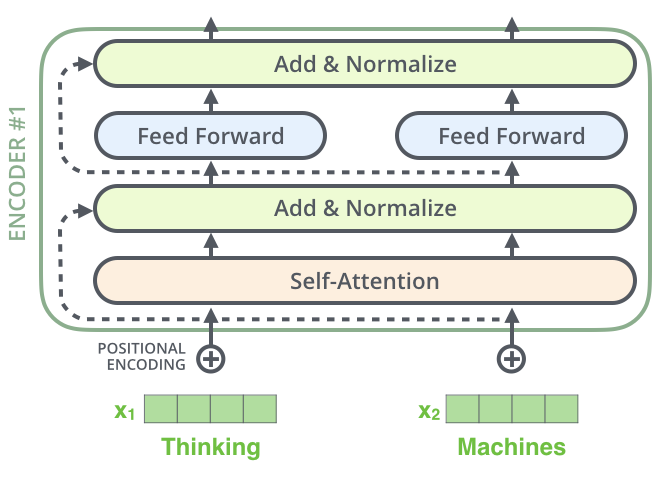
The Transformer network is a powerful deep learning architecture widely used in natural language processing tasks, including text classification. It consists of a stack of Transformer blocks, each containing two sub-layers:

1. **Self-attention layer (Multi-Head Attention, MHA):** This layer enables the network to capture dependencies between different words in a sentence. It computes weighted sums of word embeddings based on attention scores between pairs of words, reflecting the relevance of each word to others in the sentence.

2. **Feedforward layer:** This is a simple two-layer neural network that processes the output from the self-attention layer and applies a non-linear transformation to it.

The multi-head attention mechanism is a variation of the self-attention layer that calculates attention scores multiple times with different linear projections of input embeddings, enabling the network to attend to different aspects of the input embeddings in parallel.

For text classification, the Transformer network takes input text as a sequence of word embeddings and processes it through multiple Transformer blocks. The final output is a vector representation of the input text, which can be used for classification via a softmax layer. By leveraging self-attention and multi-head attention mechanisms, the network can capture semantic relationships between words and make highly accurate predictions.

Before creating the Transformer layer, we need to create the Word and Positional Embedding layers. These layers are essential for text data processing in the Transformer network.

In [ ]:
class TokenAndPositionalEmbedding(layers.Layer):
    
    def __init__(self, embedding_dims, vocab_size, seq_len, **kwargs):
        super(TokenAndPositionalEmbedding, self).__init__(**kwargs)
        
        # Initialize parameters
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.embedding_dims = embedding_dims
        self.embed_scale = tf.math.sqrt(tf.cast(embedding_dims, tf.float32))
        
        # Define layers
        self.token_embedding = layers.Embedding(
            input_dim=vocab_size, 
            output_dim=embedding_dims,
            name="token_embedding"
        )
        
        self.positional_embedding = layers.Embedding(
            input_dim=seq_len, 
            output_dim=embedding_dims,
            name="positional_embedding"
        )
    
    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        
        # Token Embedding
        token_embedding = self.token_embedding(inputs)
        token_embedding *= self.embed_scale
        
        # Positional Embedding
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positional_embedding = self.positional_embedding(positions)
        
        # Add Token and Positional Embedding
        embeddings = token_embedding + positional_embedding
        
        return embeddings
        
    
    def get_config(self):
        config = super(TokenAndPositionalEmbedding, self).get_config()
        config.update({
            'embedding_dims': self.embedding_dims,
            'vocab_size': self.vocab_size,
            'seq_len': self.seq_len,
        })
        return config


In [ ]:
# Let's look what the layer do.
temp_embeds = TokenAndPositionalEmbedding(embed_dim, vocab_size, max_seq_len)(X_train[:1])
temp_embeds

The **Embedding layer** in a **neural network** is a **crucial component** that **plays a key role** in **converting text data** into **meaningful numerical representations**. Essentially, the **Embedding layer** creates a **word embedding**(also known as the **token embedding**), which **projects** the **input indexes**, (i.e., the tokens), into a **feature space**(or vector space), that **contains unique and informative representations for each token**(or word). 

Additionally, it computes the **positional embeddings,** which represent the **positions** of the **tokens** in the **input sequence**. While traditionally, this was achieved using **sine and cosine waves**, here we have **leveraged the power of the Embedding layer** to handle this task in a **more efficient and effective manner**.

## **Transformer Layer**

In [ ]:
class TransformerLayer(layers.Layer):
    
    def __init__(self, num_heads: int, dropout_rate: float, embedding_dims: int, ff_dim: int, **kwargs):
        super(TransformerLayer, self).__init__(**kwargs)
        
        # Initialize Parameters
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.embedding_dims = embedding_dims
        self.ff_dim = ff_dim
        
        # Initialize Layers
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dims, dropout=dropout_rate)
        self.ln1 = layers.LayerNormalization(epsilon=1e-6)
        
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation='relu', kernel_initializer='he_normal'),
            layers.Dense(embedding_dims)
        ])
        self.ln2 = layers.LayerNormalization(epsilon=1e-6)
    
    def call(self, inputs):
        """Forward pass of the Transformer Layer.
        
        Args:
            inputs: Tensor with shape `(batch_size, seq_len, embedding_dims)` representing the input sequence.
        
        Returns:
            Tensor with shape `(batch_size, seq_len, embedding_dims)` representing the output sequence after applying the Transformer Layer.
        """
        
        # Multi-Head Attention
        attention = self.mha(inputs, inputs, inputs)
        
        # Layer Normalization and Residual Connection
        normalized1 = self.ln1(attention + inputs)
        
        # Feedforward Network
        ffn_out = self.ffn(normalized1)
        
        # Layer Normalization and Residual Connection
        normalized2 = self.ln2(ffn_out + normalized1)
        
        return normalized2
    
    def get_config(self):
        """Get the configuration of the Transformer Layer.
        
        Returns:
            Dictionary with the configuration of the layer.
        """
        config = super(TransformerLayer, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate,
            "embedding_dims": self.embedding_dims,
            "ff_dim": self.ff_dim
        })
        return config


In [ ]:
# Transformer layers execution
TransformerLayer(num_heads=num_heads, embedding_dims=embed_dim, ff_dim=ff_dim, dropout_rate=0.1)(temp_embeds)

# **Transformer Text Classification Model**
---

It's time to combine the **Token and Positional Embedding** layer and the **Transformer layer** to make a **Transformer Network architecture** for **text classification**.

In [ ]:
# Input layer
InputLayer = layers.Input(shape=(max_seq_len,), name="InputLayer")

# Embedding Layer
embeddings = TokenAndPositionalEmbedding(embed_dim, vocab_size, max_seq_len, name="EmbeddingLayer")(InputLayer)

# Transformer Layer
encodings = TransformerLayer(num_heads=num_heads, embedding_dims=embed_dim, ff_dim=ff_dim, dropout_rate=0.1, name="TransformerLayer")(embeddings)

# Classifier
gap = layers.GlobalAveragePooling1D(name="GlobalAveragePooling")(encodings)
drop = layers.Dropout(0.5, name="Dropout")(gap)
OutputLayer = layers.Dense(1, activation='sigmoid', name="OutputLayer")(drop)

# Model
model = keras.Model(InputLayer, OutputLayer, name="TransformerNet")

# Model Architecture Summary
model.summary()

# **Transformer Training**
---

In [ ]:
# Compile the Model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
    ]
)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

In [ ]:
# Plot metrics
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
plt.subplots_adjust(hspace=0.5)

axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Loss', fontsize=14)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].grid(True)
axes[0, 0].legend(fontsize=10)

axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Accuracy', fontsize=14)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].grid(True)
axes[0, 1].legend(fontsize=10)

axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Precision', fontsize=14)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].grid(True)
axes[1, 0].legend(fontsize=10)

axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Recall', fontsize=14)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].grid(True)
axes[1, 1].legend(fontsize=10)

fig.suptitle('Model Performance Metrics', fontsize=16, y=1.05)
plt.show()


In [ ]:
# Evaluate model performance on test data
loss, acc, precision, recall, auc = model.evaluate(X_test, y_test, verbose=0)

# Show the model performance
print('Test loss      :', loss)
print('Test accuracy  :', acc*100)
print('Test precision :', precision*100)
print('Test recall    :', recall*100)
print('Test AUC       :', auc*100)

The Embedding layer in a neural network is a crucial component that plays a key role in converting text data into meaningful numerical representations. It creates word embeddings (also known as token embeddings) that project input indexes (tokens) into a feature space or vector space containing unique and informative representations for each token or word.

In addition to token embeddings, the Embedding layer also computes positional embeddings, which represent the positions of the tokens in the input sequence. While traditional methods used sine and cosine waves for positional embeddings, we've leveraged the power of the Embedding layer to handle this task in a more efficient and effective manner. This allows the model to learn both token and positional embeddings simultaneously, capturing rich semantic and positional information from the text data.

# **Transformer Predictions**
---

In [ ]:
def decode_tokens(tokens):
    """
    This function takes in a list of tokenized integers and returns the corresponding text based on the provided vocabulary.
    
    Args:
    - tokens: A list of integers representing tokenized text.
    - vocab: A list of words in the vocabulary corresponding to each integer index.
    
    Returns:
    - text: A string of decoded text.
    """
    text = " ".join(VOCAB[int(token)] for token in tokens).strip()
    return text


In [ ]:
for _ in range(10):
    # Randomly select a text from the testing data.
    index = np.random.randint(1,len(X_test))
    tokens = X_test[index-1:index]
    label = y_test[index]

    # Feed the tokens to the model
    print(f"\nModel Prediction\n{'-'*100}")
    proba = 1 if model.predict(tokens, verbose=0)[0][0]>0.5 else 0
    pred = label_encoder.inverse_transform([proba])
    print(f"Message: '{decode_tokens(tokens[0])}' | Prediction: {pred[0].title()} | True : {label_encoder.inverse_transform([label])[0].title()}\n")

That's a great point! Machine learning models, including the Transformer-based model for text classification, make predictions based on patterns they've learned from the training data. The initial predictions you see might be influenced by the specific examples you input. It's essential to understand that the model's predictions can vary based on the input data and the learned patterns. This variability is a sign of a well-generalized model, as it's not rigidly biased towards one class.

If you input different examples, you'll likely see the model correctly classify them as either "ham" or "spam." This adaptability and ability to make accurate predictions for a variety of inputs demonstrate the model's capacity to generalize well beyond the training data. It's a positive aspect of a robust machine learning model.

In [ ]:
# # Custom Input
# text = input("Enter your Msg: ")

# # Convert into tokens
# tokens = text_vectorizer([text])

# # Feed the tokens to the model
# print(f"\nModel Predictions\n{'-'*100}")
# proba = 1 if model.predict(tokens, verbose=0)[0][0]>0.5 else 0
# pred = label_encoder.inverse_transform([proba])
# print(f"Message: '{text}' | Prediction: {pred[0].title()}")

# This is not supported.


Certainly, here's a summary of the code and its steps:

1. **SetUp:** In this section, we import necessary libraries and define constants and hyperparameters to set up the environment for the project.

2. **Data Loading:** We load the SMS spam/ham dataset, which serves as our data source for training and evaluation.

3. **Text Vectorization:** Using the TextVectorization layer from TensorFlow, we preprocess the text data. This step involves tokenization and converting the text into numerical values, making it suitable for machine learning.

4. **Transformer Network:** This section focuses on creating the Transformer network architecture using the Keras functional API. It includes the creation of token and word embeddings, positional embeddings, and a multi-head self-attention layer, all of which are crucial for understanding the relationships between words in the text.

5. **Transformer Training:** After defining the model architecture, we compile and train the Transformer network using the preprocessed SMS data. Training is performed on the training set, and the model's performance is validated on the validation set.

6. **Evaluation:** In this step, we evaluate the model on the test set to assess its generalization capabilities. We also generate plots for different evaluation metrics to visualize its performance.

7. **Custom Input:** The final section allows users to input text, and the trained model classifies it as either spam or ham, providing real-time predictions.

The project demonstrates how to build, train and evaluate a Transformer-based text classification model for spam detection, as well as how to interact with the model for custom text inputs.
**By Tanisha**
---- 